In [1]:
"""Customer Churn Prediction using Machine Learning"""

#Import necessary libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, auc, 
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from sklearn.preprocessing import StandardScaler

Load Data

In [18]:
try:
    df = pd.read_csv('customer_activity.csv')
except FileNotFoundError:
    raise FileNotFoundError(f"Dataset file '{df}' not found. Please ensure it exists in the specified path.")

In [19]:
# Preview the data
print(df.head())
print(df.info())
print(df.describe())

  customer_id          last_purchase_date  total_orders  total_spent  \
0       CUST1  2024-09-16 11:21:54.433154            44      2812.60   
1       CUST2  2024-01-14 11:21:54.433154             8      2048.99   
2       CUST3  2024-04-01 11:21:54.433154            24       371.22   
3       CUST4  2024-09-12 11:21:54.433154            11      1306.88   
4       CUST5  2024-10-17 11:21:54.433154            17      1272.04   

   average_order_value  days_since_last_purchase  churned  
0               118.68                       204        1  
1               156.03                       218        0  
2                18.28                       341        1  
3               198.96                        39        1  
4                99.29                       100        0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  --

Check for missing values

In [4]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 customer_id                 0
last_purchase_date          0
total_orders                0
total_spent                 0
average_order_value         0
days_since_last_purchase    0
churned                     0
dtype: int64


Exploratory Data Analysis

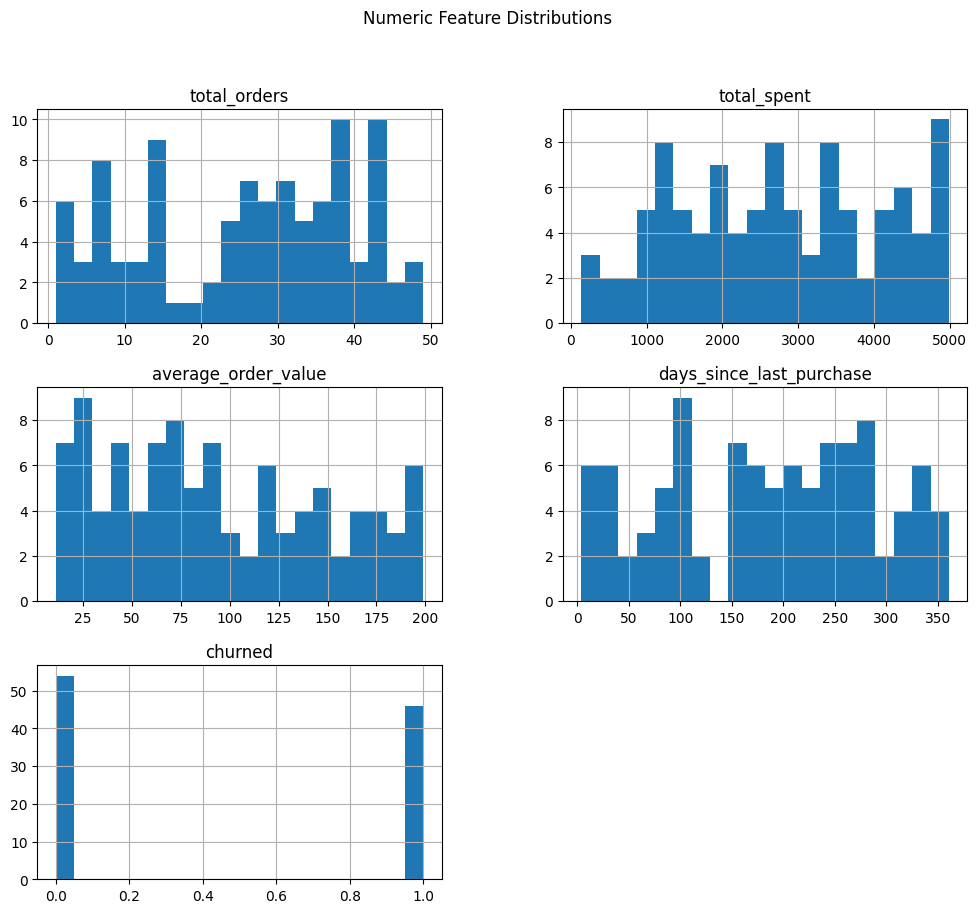

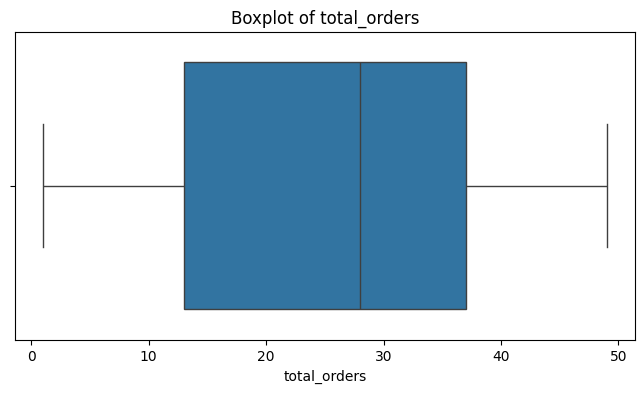

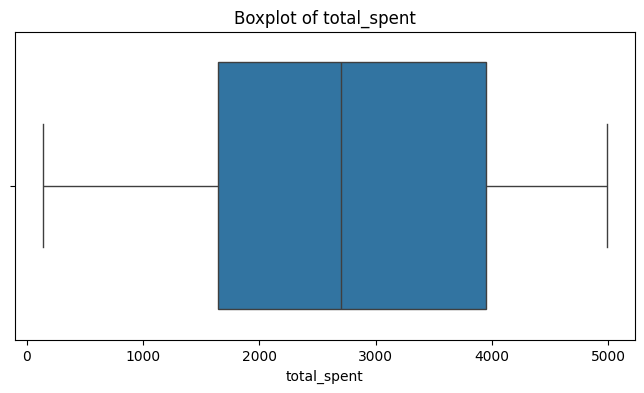

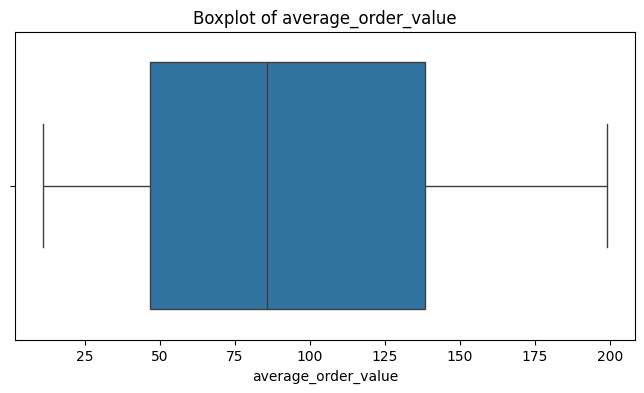

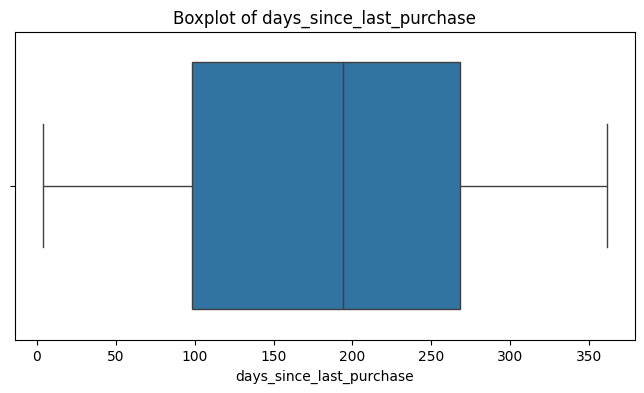

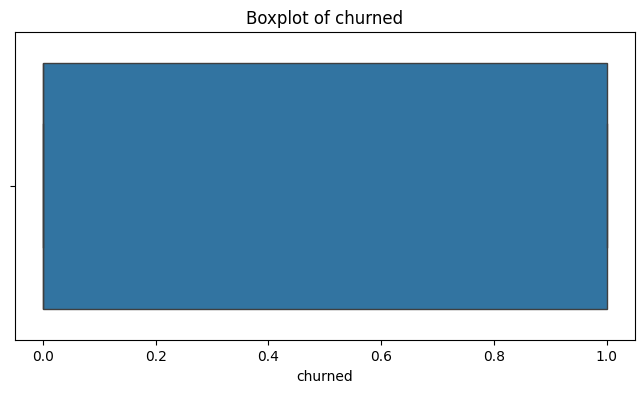

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for numeric features
df.hist(figsize=(12, 10), bins=20)
plt.suptitle("Numeric Feature Distributions")
plt.show()

# Box plots for outlier detection
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

Check whether the dataset is balanced or not

Churned distribution:
 churned
0    54
1    46
Name: count, dtype: int64


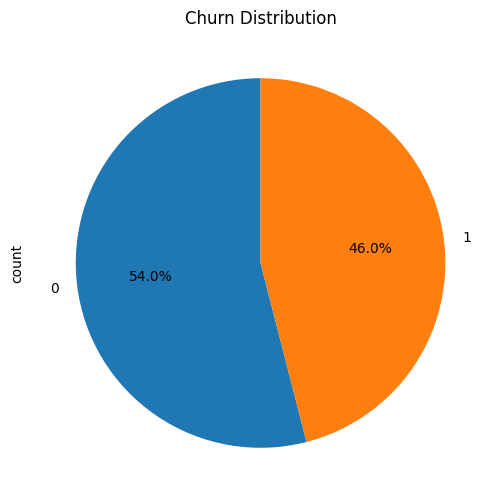

In [6]:
# Churned column value counts
print("Churned distribution:\n", df["churned"].value_counts())

# Pie chart
df["churned"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 6))
plt.title("Churn Distribution")
plt.show()

In [7]:
from datetime import datetime

# Convert last_purchase_date to datetime
df["last_purchase_date"] = pd.to_datetime(df["last_purchase_date"])

# Create derived features
df["recency"] = (datetime.now() - df["last_purchase_date"]).dt.days
df["spending_rate"] = df["total_spent"] / df["total_orders"]

# Drop last_purchase_date if recency is more informative
df.drop(columns=["last_purchase_date"], inplace=True)

Identify outliers using IQR

In [8]:
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
print("Outliers per feature:\n", outliers)

# Optionally remove or cap outliers
# Example: Cap total_spent at its 95th percentile
df["total_spent"] = df["total_spent"].clip(upper=df["total_spent"].quantile(0.95))

Outliers per feature:
 total_orders                0
total_spent                 0
average_order_value         0
days_since_last_purchase    0
churned                     0
dtype: int64


Standardization

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Hyperparameter Tuning and Model Training

In [11]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10], 'penalty': ['l2']},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10]},
    'Decision Tree': {'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10]},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]},
    'Support Vector Machine': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

In [12]:
results = {}
best_models = {}

for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    grid = GridSearchCV(model, param_grids[model_name], cv=3, scoring='roc_auc')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_models[model_name] = best_model
    y_pred = best_model.predict(X_test)

    results[model_name] = {
        'Best Parameters': grid.best_params_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]) if hasattr(best_model, 'predict_proba') else None
    }

Tuning Logistic Regression...
Tuning Random Forest...
Tuning Decision Tree...
Tuning Gradient Boosting...
Tuning Support Vector Machine...
Tuning XGBoost...


c:\Users\anant\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [10:34:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\anant\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [10:34:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\anant\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [10:34:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Print results as a table


Performance Results:

                                                          Best Parameters  \
Model                                                                       
Logistic Regression                           {'C': 0.1, 'penalty': 'l2'}   
Random Forest           {'max_depth': 10, 'min_samples_split': 2, 'n_e...   
Decision Tree                   {'max_depth': 10, 'min_samples_split': 2}   
Gradient Boosting             {'learning_rate': 0.1, 'n_estimators': 300}   
Support Vector Machine                         {'C': 10, 'kernel': 'rbf'}   
XGBoost                 {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...   

                       Accuracy Precision Recall  F1-Score   ROC-AUC  
Model                                                                 
Logistic Regression         0.6  0.384615    1.0  0.555556  0.853333  
Random Forest              0.35  0.166667    0.4  0.235294  0.506667  
Decision Tree               0.5  0.272727    0.6     0.375  0.533333  
Gradi

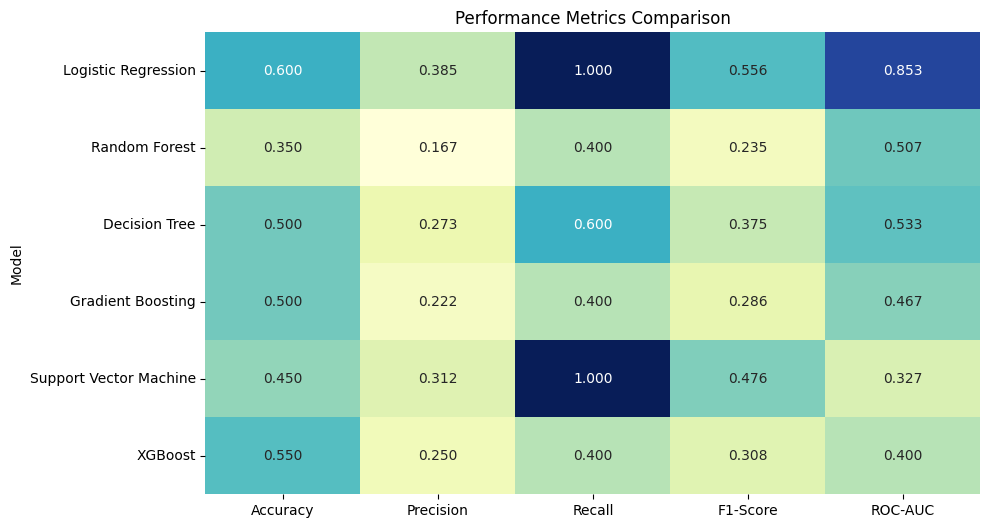

In [13]:
results_table = pd.DataFrame(results).T
results_table = results_table.rename(columns={
    'Accuracy': 'Accuracy', 
    'Precision': 'Precision', 
    'Recall': 'Recall', 
    'F1': 'F1-Score', 
    'ROC AUC': 'ROC-AUC'
})
results_table.index.name = "Model"
print("\nPerformance Results:\n")
print(results_table)

# Display the table using matplotlib for better visualization
plt.figure(figsize=(10, 6))
sns.heatmap(results_table.iloc[:, 1:].astype(float), annot=True, fmt=".3f", cmap="YlGnBu", cbar=False)
plt.title("Performance Metrics Comparison")
plt.show()


Since the model is performing well on Logistic Regression we are giving feature importance for Logistic Regression

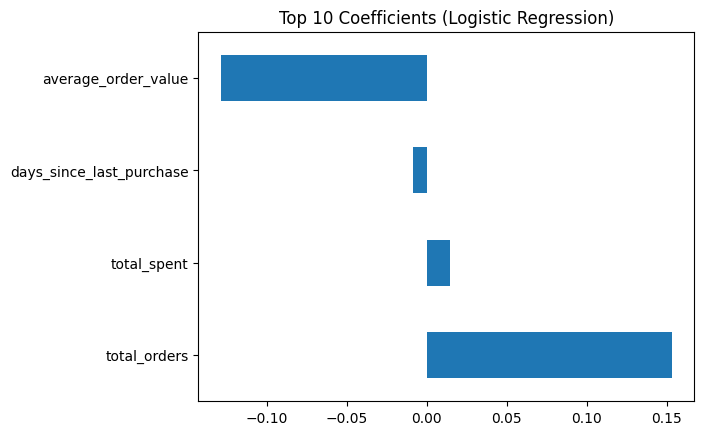

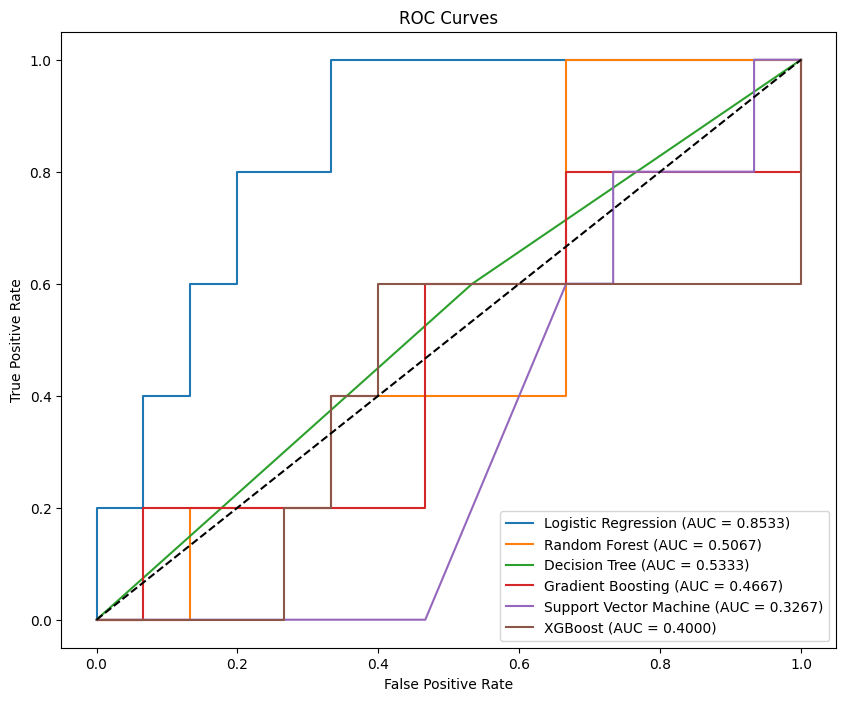

In [14]:
# Feature Importance for Logistic Regression
log_model = best_models['Logistic Regression']
if hasattr(log_model, 'coef_'):
    importance = pd.Series(log_model.coef_[0], index=X.columns)
    importance.nlargest(10).plot(kind='barh', title='Top 10 Coefficients (Logistic Regression)')
    plt.show()

# ROC Curves
plt.figure(figsize=(10, 8))
for model_name, model in best_models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Saving the Logistic Regression Model

In [15]:
import joblib
best_overall_model = 'Logistic Regression'
joblib.dump(best_models[best_overall_model], 'best_churn_model.pkl')

['best_churn_model.pkl']

In [16]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']